In [3]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import hashlib
import swifter

from tqdm.auto import tqdm

In [4]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-05-24 по 2022-05-30 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

- Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
- Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
- Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
- Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [92]:
query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [7]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [8]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


### Проведем визуальную оценку распределений ctr для групп 1 и 2

In [47]:
sns.set(rc={'figure.figsize':(10,6)})

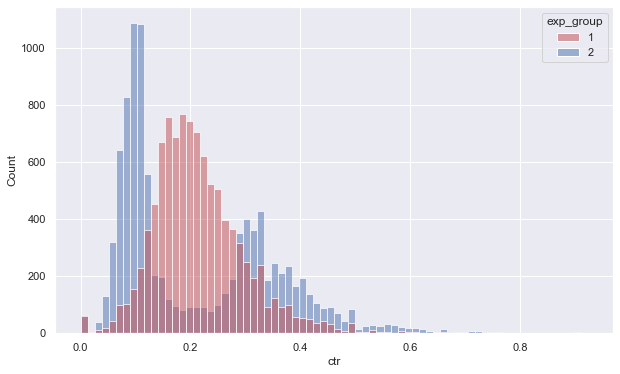

In [48]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### Распределение метрик визуально значительно отличаются

In [36]:
# посмотрим еще через тест Шапиро-Уилка
stats.shapiro(df[df.exp_group == 2].ctr) 

ShapiroResult(statistic=0.8864326477050781, pvalue=0.0)

In [102]:
stats.shapiro(df[df.exp_group == 1].ctr) 

ShapiroResult(statistic=0.9498439431190491, pvalue=0.0)

Тест Шапиро-Уилка подтверждает, что распределение ctr в группе 1 и 2 статистически значимо отличается от нормального (p-value<0.05, отклоняем гипотезу о нормальности распределения). Для сравнения результатов нужно использовать непараметрический аналог Т-теста: критерий Мана-Уитни

### Тест Манна-Уитни

In [59]:
stat, p_val = stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                                 df[df.exp_group == 2].ctr,
                                 alternative = 'two-sided')

if p_val > 0.05:
    print('Статистически значимой разницы нет','\np-value', p_val,'\nU-критерий', stat)
else:
    print('Разница статистически значима','\np-value', p_val,'\nU-критерий', stat)

Разница статистически значима 
p-value 6.0376484617779035e-56 
U-критерий 56601260.5


### Т-тест и Мана-Уитни на сглаженном CTR

In [38]:
# Функция сглаживания
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [41]:
# Рассчитаем глобальные средние ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

global_ctr_1, global_ctr_2

(0.20802680490126244, 0.1980601844115994)

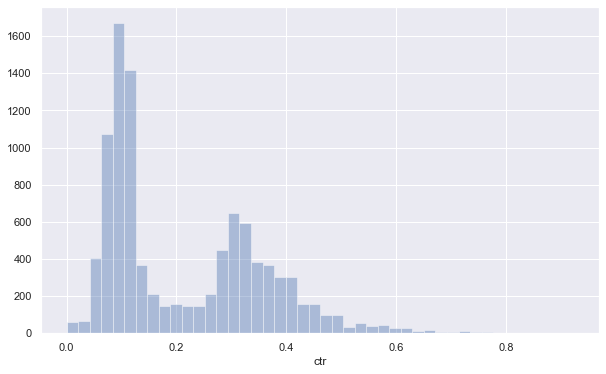

In [49]:
sns.distplot(df[df.exp_group == 2].ctr, kde = False)
plt.show()

In [45]:
group_2 = df[df.exp_group == 2].copy()
group_2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
group_2.head()

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,14,134,0.104478,0.107844
6,2,23985,7,87,0.080460,0.086851
7,2,24523,11,101,0.108911,0.113116
8,2,32420,26,128,0.203125,0.202935
9,2,24239,40,90,0.444444,0.431477


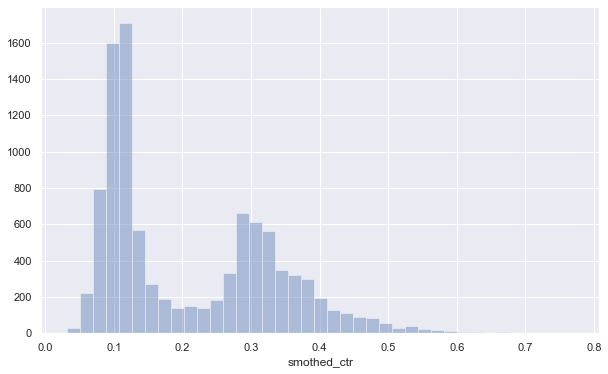

In [50]:
sns.distplot(group_2.smothed_ctr, kde = False)
plt.show()

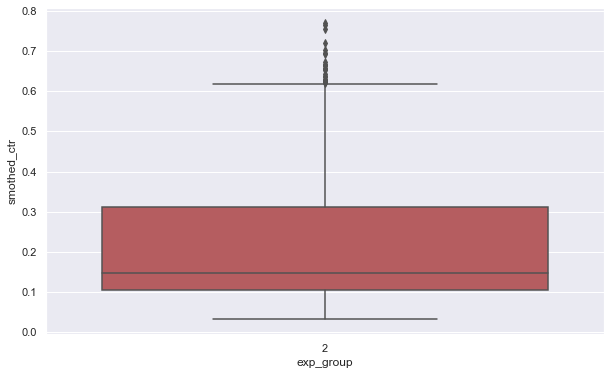

In [51]:
sns.boxplot(data = group_2, x='exp_group', y='smothed_ctr', palette = ['r', 'b'])
plt.show()

#### Сглаживание помогло убрать только часть выбросов, но не изменило характер распределения

In [54]:
group_1 = df[df.exp_group == 1].copy()
group_1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group_1.head()

,exp_group,user_id,likes,views,ctr,smothed_ctr
0,1,109963,3,15,0.200000,0.202007
1,1,26117,32,141,0.226950,0.226302
2,1,138232,18,73,0.246575,0.244104
3,1,26295,33,122,0.270492,0.268033
4,1,18392,7,32,0.218750,0.217301


In [57]:
stat, p_val = stats.mannwhitneyu(group_2.smothed_ctr, 
                                 group_1.smothed_ctr,
                                 alternative = 'two-sided')

if p_val > 0.05:
    print('Статистически значимой разницы нет','\np-value', p_val,'\nU-критерий', stat)
else:
    print('Разница статистически значима','\np-value', p_val,'\nU-критерий', stat)

Разница статистически значима 
p-value 1.6163964114270227e-61 
U-критерий 43381083.0


In [72]:
t2, p2 = stats.ttest_ind(group_2.smothed_ctr, 
                         group_1.smothed_ctr, 
                         equal_var=False)


if p2 > 0.05:
    print('Нет статистически значимой разницы','\nt-критерий = ', t2,'\np-value =', p2)
else:
    print('Есть статистически значимая разница','\nt-критерий = ', t2,'\np-value =', p2)

Есть статистически значимая разница 
t-критерий =  -2.2841320431616983 
p-value = 0.0223769815558559


### Т-тест и тест Мана-Уитни поверх бакетного преобразования


In [86]:
q = """
SELECT exp_group, bucket,
    sum(like)/sum(view) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as like,
        sum(action = 'view') as view,
        like/view as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-05-24' and '2022-05-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df_bucket = ph.read_clickhouse(q, connection=connection)

In [87]:
df_bucket.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


Посмотрим на распределение бакетных ctr в группах 1 и 2.Они имеют распределение уже более близкое к нормальному. При этом бакетный ctr в экспериментальной группе 2 меньше, чем в контрольной группе 1

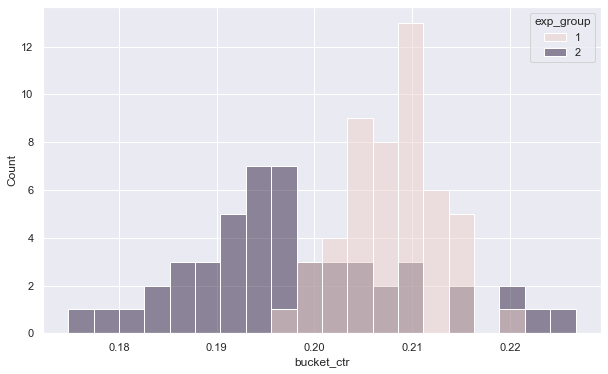

In [88]:
sns.histplot(data=df_bucket, hue='exp_group', x='bucket_ctr', bins=20)
plt.show()

In [89]:
df_bucket.groupby('exp_group', as_index=False).agg({'bucket_ctr':'mean'}) 

,exp_group,bucket_ctr
0,1,0.208122
1,2,0.198259


In [90]:
t2, p2 = stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                         df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                         equal_var=False)


if p2 > 0.05:
    print('Нет статистически значимой разницы','\nt-критерий = ', t2,'\np-value =', p2)
else:
    print('Есть статистически значимая разница','\nt-критерий = ', t2,'\np-value =', p2)

Есть статистически значимая разница 
t-критерий =  5.668234732053979 
p-value = 3.4455951649945907e-07


In [91]:
stat, p_val = stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                                 df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                                 alternative = 'two-sided')

if p_val > 0.05:
    print('Статистически значимой разницы нет','\np-value', p_val,'\nU-критерий', stat)
else:
    print('Разница статистически значима','\np-value', p_val,'\nU-критерий', stat)

Разница статистически значима 
p-value 2.859963936492646e-07 
U-критерий 1995.0


### Пуассоновский бутстреп для подсчета разницы в CTR

In [82]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [93]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [97]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [98]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

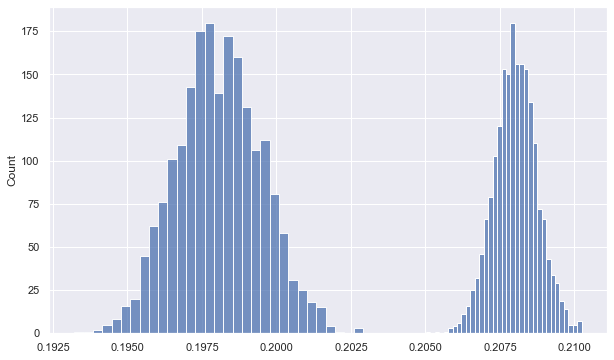

In [99]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

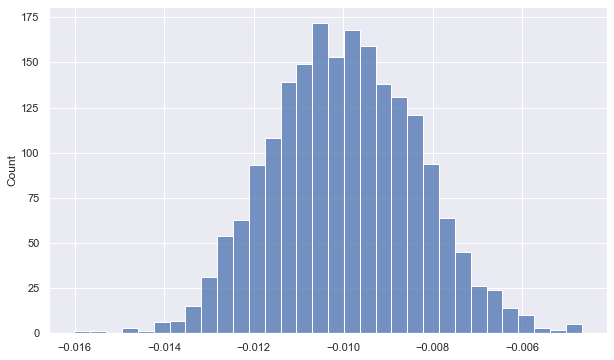

In [100]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)

### Итого

- Визуальная оценка и тест Шапиро_Уилка показала ненормальность распределения как в группе 1, так и в группе 2. При этом распределение в группе 2 обладает 2-мя ярко выраженными горбами, что сильно искажает нам среднее значение (t-test корректно работать не будет)
- U-критерий Манна-Уитни дал бы нам отклонить нулевую гипотезу. Оценка pvalue показала различия между распределениями значений ctr в группах 1 и 2
- Т-тест на сглаженном ctr и поверх бакетого преобразования также показали значимые различия между средниими значений ctr
- Тест Мана-Уитни на сглаженном ctr и поверх бакетого преобразования также показали значимые различия между распределениями значений ctr
- Пуассоновский бутстреп (мне больше нравится) для подсчета разницы в CTR показал также значимые различия между группами 1 и 2

##### Наиболее релевантной является оценка результатов АВ-теста на основании Пуассоновского бутстрепа для подсчета разницы в CTR

Бутстреп показывает, что в контрольной группе групповой ctr значительно выше, чем в тестовой группе (их распределения даже не пересекаются). Гистограмма разницы между глобальными ctr не пересекает 0, это значит, что одна группа больше другой. Поскольку мы от тестовой отнимали контрольную и значения отрицательные, то ctr больше у контрольной группы. Т.е. разница между ними отрциательная и не нулевая. И это позволяет утверждать, что группа 2 показала хуже результат по ctr, чем группа 1.

##### Почему такое могло произойти: 
По графику распределени ctr 2-й группы видно, что у одной группы пользователей ctr уменьшился, а другой увеличился. Например, новых алгоритмов рекомендации постов сработал лучше для тех пользователей, у кого мало друзей, и наоборот. У пользователей, у кого много друзей, была перенасыщена лента нерелевантными постами, что и показало низкий ctr.

##### Общая рекомендация: 
Новый алгоритм не стоит раскатывать на всех пользователей, поскольку он способен ухудшить общий ctr пользователей. Следует передать результат команде дата саентистов для улучшения алгоритма. 